Source: https://www.youtube.com/watch?v=GeqRkj89eyA&t=11s

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt, cm
from matplotlib import colors
import torchvision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from local_module import dir_file_path, H5Dataset, MulTransform
from torch.utils.data import ConcatDataset, DataLoader, Subset
import os
import joblib
import random
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from collections import defaultdict

/home/phiankha/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

Prepare multi-dataset

In [ ]:
labels_names, labels_paths = dir_file_path(root_dir='/home/phiankha/Desktop/Summer-Student-2024-Project/Clustered_model/KMeans_model/Labels')

training_names, training_paths = dir_file_path(root_dir='/home/phiankha/Desktop/Summer-Student-2024-Project/Preparation/data/raw/training')
training_names, training_paths = training_names[100:], training_paths[100:]

testing_names, testing_paths = dir_file_path(root_dir='/home/phiankha/Desktop/Summer-Student-2024-Project/Preparation/data/raw/testing')
testing_names, testing_paths = testing_names, testing_paths

validation_names, validation_paths = dir_file_path(root_dir='/home/phiankha/Desktop/Summer-Student-2024-Project/Preparation/data/raw/validation')
validation_names, validation_paths = validation_names, validation_paths

In [ ]:
def match_labels(data_names, labels_paths):
    matched_labels = []
    for data_name in data_names:
        data_name = data_name.replace('.h5', '')
        for label in labels_paths:
            if data_name in label:
                matched_labels.append(label)
                break  # Assuming there's only one matching label per data_name
    return matched_labels

# Match labels with names for training, testing, and validation
training_labels = match_labels(training_names, labels_paths)
testing_labels = match_labels(testing_names, labels_paths)
validation_labels = match_labels(validation_names, labels_paths)

# Display the lengths and first few elements to verify correctness
print(f'Total Labels: {len(labels_names)}, Labels: {labels_names[:5]}')
print(f'Total Training Names: {len(training_names)}, Training Names: {training_names[:5]}')
print(f'Total Training Labels: {len(training_labels)}, Training Labels: {training_labels[:5]}')
print(f'Total Testing Names: {len(testing_names)}, Testing Names: {testing_names[:5]}')
print(f'Total Testing Labels: {len(testing_labels)}, Testing Labels: {testing_labels[:5]}')
print(f'Total Validation Names: {len(validation_names)}, Validation Names: {validation_names[:5]}')
print(f'Total Validation Labels: {len(validation_labels)}, Validation Labels: {validation_labels[:5]}')

Total Labels: 848, Labels: ['Kmeans_siO2_PPG_fastshutter_05_00001_data_000001_labels.joblib', 'Kmeans_siO2_PPG_fastshutter_05_00002_data_000001_labels.joblib', 'Kmeans_siO2_PPG_fastshutter_05_00003_data_000001_labels.joblib', 'Kmeans_siO2_PPG_fastshutter_05_00004_data_000001_labels.joblib', 'Kmeans_siO2_PPG_fastshutter_05_00005_data_000001_labels.joblib']
Total Training Names: 1, Training Names: ['siO2_PPG_fastshutter_05_00500_data_000001.h5']
Total Training Labels: 1, Training Labels: ['/home/phiankha/Desktop/Summer-Student-2024-Project/Clustered_model/KMeans_model/Labels/Kmeans_siO2_PPG_fastshutter_05_00500_data_000001_labels.joblib']
Total Testing Names: 1, Testing Names: ['siO2_PPG_fastshutter_05_00701_data_000001.h5']
Total Testing Labels: 1, Testing Labels: ['/home/phiankha/Desktop/Summer-Student-2024-Project/Clustered_model/KMeans_model/Labels/Kmeans_siO2_PPG_fastshutter_05_00701_data_000001_labels.joblib']
Total Validation Names: 1, Validation Names: ['siO2_PPG_fastshutter_05_0

Prepare datasets

In [ ]:
# Prepare Datasets using list comprehensions

transform = torchvision.transforms.Compose([MulTransform(
    '/home/phiankha/Desktop/Summer-Student-2024-Project/Preparation/data/masks/Det_029_mask.h5', 'blemish')])

training_list_datasets = [H5Dataset(path, labels_path=label, group='entry/data/data', transform=transform) 
                          for path, label in zip(training_paths, training_labels)]
testing_list_datasets = [H5Dataset(path, labels_path=label, group='entry/data/data') 
                         for path, label in zip(testing_paths, testing_labels)]
validation_list_datasets = [H5Dataset(path, labels_path=label, group='entry/data/data') 
                            for path, label in zip(validation_paths, validation_labels)]

# Create ConcatDatasets for each set
train_dataset = ConcatDataset(training_list_datasets)
test_dataset = ConcatDataset(testing_list_datasets)
val_dataset = ConcatDataset(validation_list_datasets)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([32, 514, 1030]) torch.Size([32])


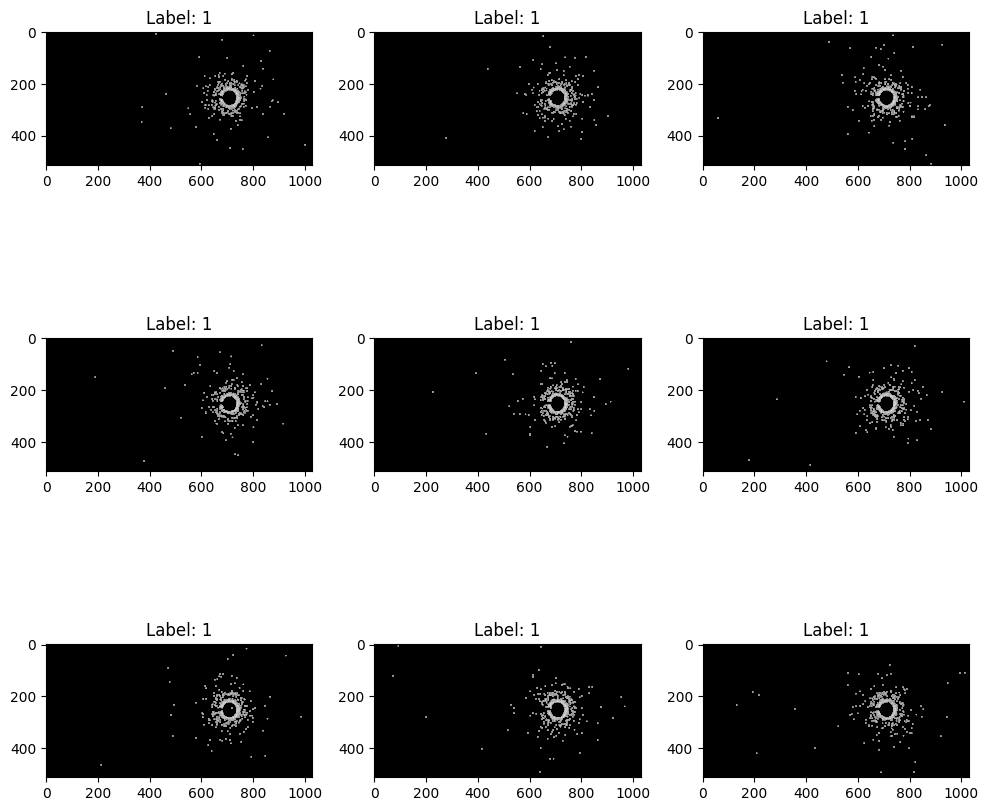

In [ ]:
# Number of images to display
num_images = 9

# Create a figure and a grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3x3 grid
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

# Iterate through the data loader and display images
for images, labels in train_loader:
    print(images.shape, labels.shape)

    # Display up to 9 images
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray', norm=colors.PowerNorm(gamma=0.1))  # Change dimensions for proper display if necessary
        ax.set_title(f'Label: {labels[i]}')
    break  # Exit after processing the first batch

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


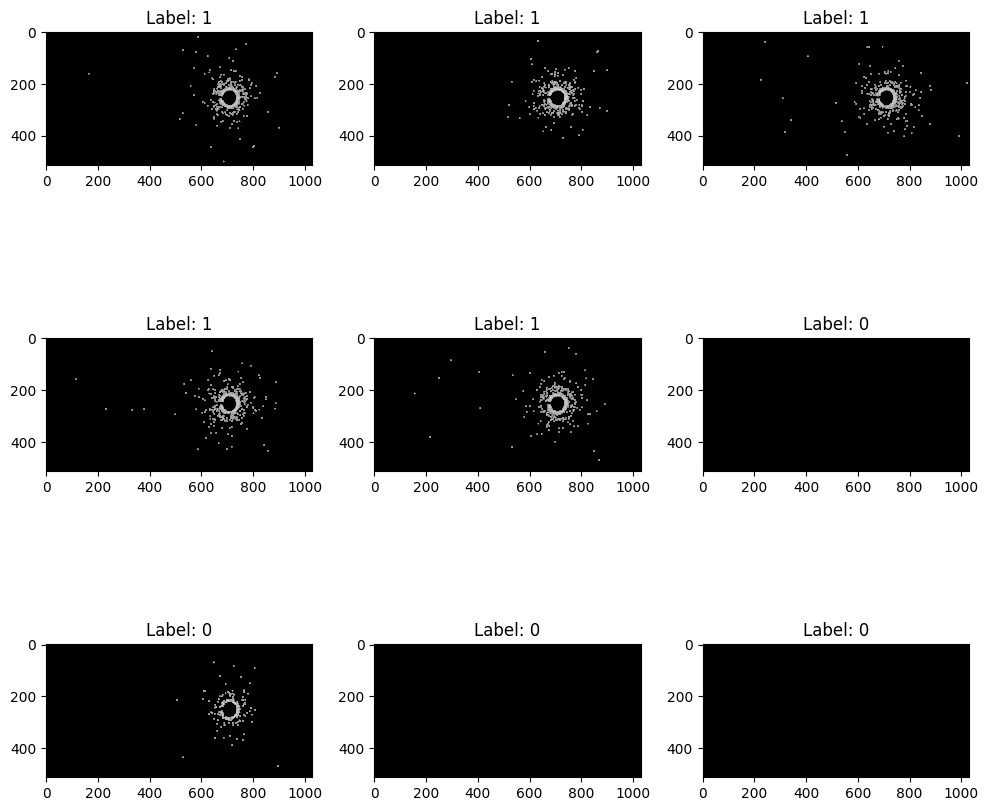

In [ ]:
# Number of images to display
num_images = 9

# Desired numbers of images per label
num_images_label_0 = 4
num_images_label_1 = 5

# Counters for each label
count_label_0 = 0
count_label_1 = 0

# Create a figure and a grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3x3 grid
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

# Initialize index for plotting
plot_index = 0

# Iterate through the data loader and selectively display images
for images, labels in train_loader:
    # Iterate over the batch of images and labels
    for i in range(len(labels)):
        # Plot only if we haven't reached the desired number of images
        if plot_index < num_images:
            if labels[i].item() == 0 and count_label_0 < num_images_label_0:
                ax = axes[plot_index]
                ax.imshow(images[i], cmap='gray', norm=colors.PowerNorm(gamma=0.1))
                ax.set_title(f'Label: {labels[i]}')
                count_label_0 += 1
                plot_index += 1
            elif labels[i].item() == 1 and count_label_1 < num_images_label_1:
                ax = axes[plot_index]
                ax.imshow(images[i], cmap='gray', norm=colors.PowerNorm(gamma=0.1))
                ax.set_title(f'Label: {labels[i]}')
                count_label_1 += 1
                plot_index += 1
        
        # Break if we have plotted the required number of images
        if plot_index >= num_images:
            break
    
    # Break the outer loop if we have enough images
    if plot_index >= num_images:
        break

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.output(x)
        return x

# Instantiate model
model = MLP(input_size=514*1030)

# model = torchvision.ops.MLP(514*1030, [16, 8, 4, 2])

In [ ]:
# Initialize a dictionary to keep track of label counts
label_counts = defaultdict(int)

# Iterate over the train_loader to accumulate label counts
for _, labels in train_loader:
    unique_labels, counts = np.unique(labels.numpy(), return_counts=True)
    for label, count in zip(unique_labels, counts):
        label_counts[label] += count

# Prepare data for compute_class_weight
labels = np.array(list(label_counts.keys()))
counts = np.array(list(label_counts.values()))

In [ ]:
# # print(label_counts)
# print(labels)
# print(counts)

$ \text{weight} = \frac{\text{number of total data}}{\text{number of classes} \times \text{number of data in i-th class}}$

In [ ]:
# Compute class weights using the accumulated label counts
class_weights = compute_class_weight(class_weight='balanced', classes=labels, y=np.repeat(labels, counts))

# Convert class weights to a tensor for PyTorch
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
print(class_weights)

In [ ]:
# Set my own weight
# This numbers come from my own calculating by using only 1 dataset as a sample
# class_weights_tensor = torch.tensor([187.5 , 0.50133689839 ], dtype=torch.float)

# Try another weight to see if anything changes
# class_weights_tensor = torch.tensor([200.0 , 0.3 ], dtype=torch.float)

In [ ]:
# Define the model, criterion, and optimizer
# model = MLP(input_size=514*1030)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 10  # Number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for images, labels in train_loader:
        # images = images.reshape(-1, 514*1030)
        labels = labels.long()  # Converts tensor of labels to int64 type
        # print(labels.shape, images.shape)
        # print(images, labels)
        # break  # Exit after processing the first batch
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print the average loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    
    # break  # Exit after processing the first epoch

    # # Validation
    # model.eval()  # Set the model to evaluation mode
    # val_loss = 0.0
    # with torch.no_grad():  # No gradient calculation
    #     for images, labels in val_loader:
    #         # images = images.reshape(-1, 514*1030)
    #         labels = labels.long()  # Converts tensor of labels to int64 type
    #         outputs = model(images)
    #         loss = criterion(outputs, labels)
    #         val_loss += loss.item()
    
    # # Print the validation loss
    # print(f"Validation Loss: {val_loss/len(val_loader)}")

Epoch 1/10, Loss: 0.0373030940788359
Epoch 2/10, Loss: 0.0018846625852289589
Epoch 3/10, Loss: 0.0016272428807071187
Epoch 4/10, Loss: 0.0014745841590991676
Epoch 5/10, Loss: 0.001410580909200786
Epoch 6/10, Loss: 0.001349952779438799
Epoch 7/10, Loss: 0.0012765771198972172
Epoch 8/10, Loss: 0.0011982333766538547
Epoch 9/10, Loss: 0.0011020616580232003
Epoch 10/10, Loss: 0.0009605330175650414


In [ ]:
# Initial prediction and labels list
predictions = []
labels = []

model.eval()
with torch.no_grad():
  for images, target in test_loader:
    # images = images.reshape(-1, 28*28)
    outputs = F.softmax(model(images), dim=1)
    print(outputs)
    _, predicted = torch.max(outputs.data, 1)

    # Append predictions and labels to the lists
    predictions.extend(predicted.tolist())
    labels.extend(target.tolist())

tensor([[9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9990e-01, 1.0288e-04],
        [9.9996e-01, 3.8576e-05],
        [9.9996e-01, 4.3189e-05],
        [9.9996e-01, 4.3358e-05],
        [9.9996e-01, 4.1944e-05],
        [9.9996e-01, 4.0311e-05],
        [9.9996e-01, 4.2249e-05],
        [9.9996e-01, 4.0794e-05],
        [9.9996e-01, 4.1820e-05],
        [9.9996e-01, 4.0807e-05],
        [9.9996e-01, 4.2487e-05],
        [9.9996e-01, 4.2616e-05],
        [9.9996e-01, 4.3433e-05],
        [9.9995e-01, 4.7258e-05],
        [9.999

In [ ]:
print(predictions)
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<function confusion_matrix at 0x7fd7cb1da050>
              precision    recall  f1-score   support

           0       0.00      1.00      0.01        16
           1       0.00      0.00      0.00      5984

    accuracy                           0.00      6000
   macro avg       0.00      0.50      0.00      6000
weighted avg       0.00      0.00      0.00      6000



/home/phiankha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/phiankha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/phiankha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


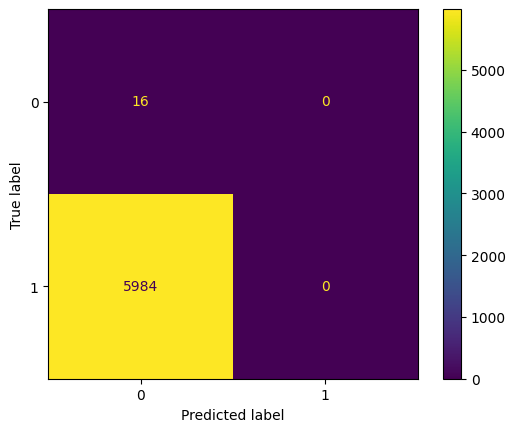

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
print(confusion_matrix)

# Classification report
print(classification_report(labels, predictions))

# Display result
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()